# Null-Steering-Beamformer (NSB) algorithm applied on a uniform linear array (ULA)

In the following notebook we demonstrate the NSB algorithm and create a dataset to train the neural networks in the following lesson.

**IMPORTANT:**

After the dataset production, a file *total_dataset.csv* will appear on the "Files" section on the left side of this notebook. Make sure to download the file before closing the notebook.

## Produce a Direction of Arrival (DoA) matrix of random signals
The direction of arrival of a signal is expressed only using the elevation rotation θ.

*   Simple scenario of 1 signal of interest (SoI) and 2 signals of avoidance (SoAs)
*   Minimum angular distance between adjacent signals: 6 (degrees)
*   Operational range: [30, 150] (degrees)
*   Decimal accuracy of 0.1 (degrees)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def produce_doas(M, mintheta, theta_start, theta_stop, maxcount, accuracydigits):
    count = 0 # Counts records
    doa_mat = np.zeros((maxcount, M)) # Empty array to store DoAs
    np.random.seed()  # Shuffle the seed for randomness
    while count < maxcount:
        minDth = 0
        while minDth < mintheta: # Minimum angular distance constraint

            # Create a DoA array of M incoming signals
            doas = theta_start + (theta_stop - theta_start) * np.random.rand(M)
            # Round every DoA
            doas = np.round(doas, accuracydigits)

            # Calculate the minimum distance in this array
            minDth = np.min(np.diff(np.sort(doas)))

        # Save the DoA array
        doa_mat[count, :] = doas
        count += 1 # Counter increase

    return doa_mat

# Example usage
M = 3 # number of incoming signals
mintheta = 6 # minimum distance between adjacent signals
theta_start = 30 # operational range min
theta_stop = 150 # operational range max
maxcount = 10 # total number of DoA sets
accuracydigits = 1 # decimal accuracy on the produced DoA angles

# Create the DoA matrix
theta_mat = produce_doas(M, mintheta, theta_start, theta_stop, maxcount, accuracydigits)
print("Example:\n\n",theta_mat[0:5])

Example:

 [[145.2 134.4  95.6]
 [134.4 104.6  82.1]
 [102.1  74.2  38.1]
 [ 49.   86.6 115.8]
 [131.   95.2  43.8]]


## Calculate the steering vector for a ULA of N-elements.

In [ ]:
def steering_vector(theta, N):
    # Simplified steering vector for angle theta considering a ULA of N elements,
    # isotropic point sources, and the distance between elements: lamda/2
    return np.exp(-1j * np.arange(N) * np.pi * np.cos(np.deg2rad(theta)))

## The Null-Steering-Beamforming (NSB) Algorithm
This implementation considers the first of input DoAs to be the desired one (SoI) and the rest to be the interferences (SoAs).

In [ ]:
def NSB(doas, N):
  M = len(doas)

  # Compute the steering matrix A
  A = np.array([steering_vector(doas[i], N) for i in range(M)]).T

  # Calculate Hermitian of A
  AH = A.conj().T

  # AH and A multiplication and diagonal loading
  AHA = np.matmul(AH, A) + 1e-6 * np.eye(M)

  # Unit vector
  u1 = np.zeros(len(doas)).T
  u1[0]= 1

  # Final steps
  wNSB = np.matmul(np.matmul(A,np.linalg.inv(AHA)),u1)

  return wNSB

### Example:
Let us test on a random list of the generated DoAs

Function to plot radiation pattern:

In [ ]:
def plot_radiation_pattern(weights, doas, num_points=360, title=None):
    """
    Plots the radiation pattern of a ULA based on provided weights.

    Parameters:
        weights (numpy array): Complex weights of the antenna elements.
        doas (list of floats): Angles of interest in degrees where lines should be drawn.
        num_points (int): Number of points to calculate in the plot (default is 360).
    """
    M = len(weights)  # Number of array elements
    d = 0.5  # Element spacing in wavelengths (assuming lambda = 1)
    theta = np.linspace(0, 2 * np.pi, num_points)  # Angles from 0 to 2*pi

    # Array factor calculation
    k = 2 * np.pi  # Assuming wavelength lambda = 1
    array_factor = np.zeros(num_points, dtype=complex)

    for m in range(M):
        array_factor += weights[m] * np.exp(1j * k * d * m * np.cos(theta))

    # Normalizing array factor
    array_factor = np.abs(array_factor) / np.max(np.abs(array_factor))

    # Convert to dB
    array_factor_db = 20 * np.log10(array_factor + 1e-10)  # Adding small value to avoid log(0)

    # Plotting
    plt.figure()
    plt.polar(theta, array_factor_db)
    if title==None:
      plt.title('Radiation Pattern')
    else:
      plt.title(title)

    # Add lines at specified angles (doas)
    for i, doa in enumerate(doas):
        doa_rad = np.deg2rad(doa)  # Convert degrees to radians
        color = 'blue' if i == 0 else 'red'
        plt.polar([doa_rad, doa_rad], [np.min(array_factor_db), np.max(array_factor_db)], color=color)
        plt.text(doa_rad, np.max(array_factor_db), f'{doa}°', color=color, fontsize=12,
                 horizontalalignment='center', verticalalignment='bottom')

    plt.show()

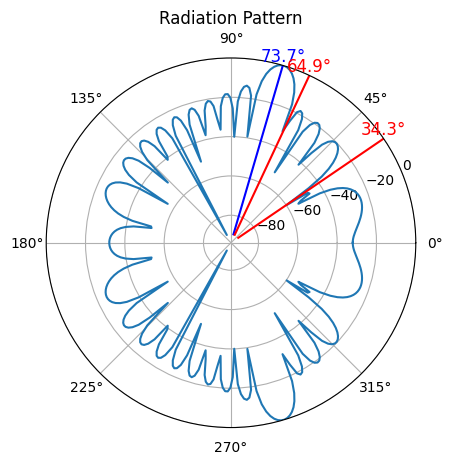

(BLUE) SOI: 73.7, (RED) SOA1: 64.9, SOA2: 34.3


In [ ]:
N = 16 # Set the number of array elements

# Extract a random list of 3 DoAs
doas = theta_mat[np.random.randint(0,theta_mat.shape[0])]

# Get the beamforming weight vector using the NSB
weights = NSB(doas, N)

# Plot the radiation pattern and observe the DoAs of the list
plot_radiation_pattern(weights, doas)

print(f"(BLUE) SOI: {doas[0]}, (RED) SOA1: {doas[1]}, SOA2: {doas[2]}")

## Dataset Creation
In the following snippet we will create a dataset of multiple records. For each record,

*   the **input** will be a 3x1 array with random combinations of DoAs, and
*   the **output** will be a 32x1 array containing the *Realistic* (16 values) and *Imaginary* (16 values) parts of the weight vector produced by the NSB algorithm.



In [ ]:
N = 16  # number of array elements
M = 3  # number of incoming signals (1st signal is the desired one)
mintheta = 6  # minimum difference between DoA values (in degrees) accepted for calculations
theta_start = 30 # Operational range minimum
theta_stop = 150 # Operational range maximum
maxcount = 100000  # total number of records
accuracydigits = 1  # defines the number of digits to round angles
theta_mat = produce_doas(M, mintheta, theta_start, theta_stop, maxcount, accuracydigits)
print(f"Done! \nProduced a {theta_mat.shape} matrix of random DoA scenarios!")

Done! 
Produced a (1000000, 3) matrix of random DoA scenarios!


In [ ]:
from tqdm import tqdm
from google.colab import files

# Initialize the progress bar
pbar = tqdm(total=maxcount, desc="Dataset Progress", unit="record")

dataset = np.zeros((maxcount,M+2*N)) # Empty matrix to store the dataset
for idx in range(maxcount):

  # Get the NSB weights
  weights = NSB(theta_mat[idx], N)

  # Store the dataset "input"
  dataset[idx, :M] = theta_mat[idx] # First M columns

  # Store the dataset "output"
  dataset[idx, M:M+N] = np.real(weights) # Subsequent N columns
  dataset[idx,M+N:]   = np.imag(weights) # Subsequent N columns

  # Update the progress bar
  pbar.update(1)

print("\nDataset Produced!")

# Save the dataset as a .csv file
np.savetxt("total_dataset.csv", dataset, delimiter = ',')

Dataset Progress: 100%|█████████▉| 999871/1000000 [03:01<00:00, 6251.79record/s]

Dataset Produced!


### Download the dataset to your local drive:

In [ ]:
# Download File:
print("Downloading dataset...\n")
files.download('total_dataset.csv')
print("\nDataset downloaded!")

In [ ]:
# How to import the dataset
total_dataset = np.loadtxt("total_dataset.csv",delimiter = ',')

# Show an example of input-output
random_idx = np.random.randint(0,total_dataset.shape[0])
print(f"Random record example\n\nInput DoAS (degrees):{total_dataset[random_idx,:M]}\n\nOutput Weights:\n(REAL) {total_dataset[random_idx,M:M+N]}\n\n(IMAGINARY) {total_dataset[random_idx,M+N:]}")

Example

Input DoAS (degrees):[135.2  79.6 117.6]

Output Weights:
(REAL) [ 0.06266671 -0.03767646 -0.01566457  0.05812887 -0.05256334  0.01139335
  0.04322227 -0.06360403  0.03199213  0.02143485 -0.06106164  0.04935948
 -0.00325626 -0.04593321  0.06306389 -0.02658664]

(IMAGINARY) [ 0.00080912  0.05182366 -0.05862287  0.02453388  0.02938691 -0.06232791
  0.04474893  0.00474298 -0.05517673  0.0584053  -0.01691309 -0.03449836
  0.0630101  -0.03965047 -0.01132044  0.05675316]


### !! REMINDER: PLEASE DOWNLOAD THE DATASET FROM THE "FILES" SECTION !!

In [ ]:
from google.colab import files
files.download('total_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>